In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ao3-8k/AO3EntireWork_v5.csv


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
lemmatizer = nltk.wordnet.WordNetLemmatizer()

# Simplifies input by removing extra whitespacs and numbers.
def simplify_input(content): 
    content = re.sub("\\s", " ", content)
    content = re.sub("\\d", "", content)
    content = re.sub("[;]", "", content)
    content = content.lower().split()
    return content

# Reduces each word to a working English base word (lemma).
def lemmatizing(content):
    le_content = str("")
    for string in content:
        le_content += lemmatizer.lemmatize(string, pos="v") + " "
    le_2 = str("")
    for s in le_content.split():
        le_2 += lemmatizer.lemmatize(s, pos='a') + " "
    le_3 = str("")
    for s in le_2.split():
        le_3 += lemmatizer.lemmatize(s, pos='n') + " "
    return le_3

In [ ]:
# Read in the dataset and apply data preprocessing
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
data = pd.read_csv("/kaggle/input/ao3-8k/AO3EntireWork_v5.csv", index_col = False)
data['simplified_input'] = data['content'].map(lambda x: simplify_input(x))
data['simplified_input'] = data['simplified_input'].map(lambda x: lemmatizing(x))

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [ ]:
# Randomly sample data from the original dataset. Hold a backup copy in data_backup
data_backup = data
data = data.sample(n=1500, random_state=42)

In [5]:
#Import libraries
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

# Preprocessing: Split genres into lists for multi-label encoding
data['genres_list'] = data['genres'].apply(lambda x: x.split(','))

# Multi-Label Binarization
mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(data['genres_list'])

In [7]:
data['genres'].value_counts()

genres
Comedy,Romance                179
Romance                       129
Fantasy                       102
Crime                          94
Comedy                         78
                             ... 
Action,Horror,Mystery           1
Action,Fantasy,Superheroes      1
Action,Adventure,Mystery        1
Crime,Horror,Superheroes        1
Comedy,Horror,Superheroes       1
Name: count, Length: 145, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(data['simplified_input'], encoded_labels, test_size=0.2, random_state=42)

In [9]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
max_length = 4096

train_encodings = tokenizer(
    train_texts.tolist(),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)
test_encodings = tokenizer(
    test_texts.tolist(),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Garbage collection to prevent memory issues
import gc
gc.collect()

12

In [12]:

from torch.optim import AdamW
# Load the model
num_labels = len(mlb.classes_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=num_labels)
model = torch.nn.DataParallel(model).to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
criterion = torch.nn.BCEWithLogitsLoss()

# Create DataLoader
batch_size = 2
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, hamming_loss, classification_report

# Initialize lists to store metrics
training_losses = []
validation_losses = []
validation_accuracies = []
hamming_losses = []
label_based_accuracies = []
best_model_epoch = -1
best_model_loss = float('inf')
best_model_accuracy = 0
best_model_hamming = 0
best_model_label_accuracy = 0
best_model_validation_loss = 0

# Parameters for early stopping and fine-tuning
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Best validation loss seen so far
epochs_no_improve = 0  # Counter for epochs without improvement

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training loop
epochs = 25
for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Training phase
    for batch in train_dataloader:
        b_input_ids, b_attention_mask, b_labels = (t.to(device) for t in batch)
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        loss = criterion(outputs.logits, b_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}: Training Loss = {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_attention_mask, b_labels = (t.to(device) for t in batch)
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            loss = criterion(outputs.logits, b_labels)
            val_loss += loss.item()

            # Store predictions and true labels
            preds = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (preds > 0.3).astype(int)  # Apply threshold for multi-label classification
            all_preds.extend(preds)
            all_labels.extend(b_labels.cpu().numpy())

    avg_val_loss = val_loss / len(test_dataloader)
    validation_losses.append(avg_val_loss)

    # Calculate metrics
    val_accuracy = accuracy_score(all_labels, all_preds)
    hamming = hamming_loss(all_labels, all_preds)

    # Label-based accuracy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    label_correct = (all_preds == all_labels).sum(axis=0)
    label_total = all_labels.shape[0]
    label_accuracy = label_correct / label_total
    avg_label_accuracy = label_accuracy.mean()
    label_based_accuracies.append(avg_label_accuracy)

    validation_accuracies.append(val_accuracy)
    hamming_losses.append(hamming)

    print(f"Epoch {epoch + 1}: Validation Loss = {avg_val_loss:.4f}, Perfect Prediction Accuracy = {val_accuracy:.4f}, "
          f"Hamming Loss = {hamming:.4f}, Partial Prediction Accuracy = {avg_label_accuracy:.4f}")

    # Early stopping and learning rate adjustment
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_epoch = epoch + 1
        best_model_accuracy = val_accuracy
        best_model_hamming = hamming
        best_model_label_accuracy = avg_label_accuracy
        best_model_validation_loss = avg_val_loss
        print("Validation loss improved. Saving model...")
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")
        scheduler.step(avg_val_loss)

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}.")
        break

Initializing global attention on CLS token...
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1: Training Loss = 0.4536
Epoch 1: Validation Loss = 0.4184, Perfect Prediction Accuracy = 0.1350, Hamming Loss = 0.1933, Partial Prediction Accuracy = 0.8067
Validation loss improved. Saving model...


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 2: Training Loss = 0.3912
Epoch 2: Validation Loss = 0.3908, Perfect Prediction Accuracy = 0.1475, Hamming Loss = 0.1810, Partial Prediction Accuracy = 0.8190
Validation loss improved. Saving model...


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 3: Training Loss = 0.3421
Epoch 3: Validation Loss = 0.3717, Perfect Prediction Accuracy = 0.1525, Hamming Loss = 0.1817, Partial Prediction Accuracy = 0.8183
Validation loss improved. Saving model...


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 4: Training Loss = 0.2980
Epoch 4: Validation Loss = 0.3708, Perfect Prediction Accuracy = 0.1500, Hamming Loss = 0.1970, Partial Prediction Accuracy = 0.8030
Validation loss improved. Saving model...


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 5: Training Loss = 0.2556
Epoch 5: Validation Loss = 0.3983, Perfect Prediction Accuracy = 0.1400, Hamming Loss = 0.1923, Partial Prediction Accuracy = 0.8078
No improvement in validation loss for 1 epoch(s).


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 6: Training Loss = 0.2142
Epoch 6: Validation Loss = 0.3786, Perfect Prediction Accuracy = 0.2025, Hamming Loss = 0.1680, Partial Prediction Accuracy = 0.8320
No improvement in validation loss for 2 epoch(s).


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 7: Training Loss = 0.1809
Epoch 7: Validation Loss = 0.4241, Perfect Prediction Accuracy = 0.2000, Hamming Loss = 0.1880, Partial Prediction Accuracy = 0.8120
No improvement in validation loss for 3 epoch(s).


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 8: Training Loss = 0.1463
Epoch 8: Validation Loss = 0.4225, Perfect Prediction Accuracy = 0.1675, Hamming Loss = 0.1815, Partial Prediction Accuracy = 0.8185
No improvement in validation loss for 4 epoch(s).


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 9: Training Loss = 0.1137
Epoch 9: Validation Loss = 0.4492, Perfect Prediction Accuracy = 0.2025, Hamming Loss = 0.1690, Partial Prediction Accuracy = 0.8310
No improvement in validation loss for 5 epoch(s).
Early stopping triggered at epoch 9.


In [ ]:
# Save the trained model
torch.save(model.state_dict(), "/kaggle/working/best_model.pth")


Detailed Classification Report:
              precision    recall  f1-score   support

      Action       0.48      0.62      0.54        61
   Adventure       0.45      0.31      0.37        54
      Comedy       0.66      0.50      0.57       105
       Crime       0.50      0.72      0.59        64
     Fantasy       0.61      0.62      0.62        95
      Horror       0.48      0.72      0.58        69
     Mystery       0.46      0.44      0.45        52
     Romance       0.63      0.61      0.62       175
      Sci-Fi       0.66      0.64      0.65        61
 Superheroes       0.58      0.70      0.63        43

   micro avg       0.56      0.59      0.58       779
   macro avg       0.55      0.59      0.56       779
weighted avg       0.57      0.59      0.57       779
 samples avg       0.60      0.63      0.57       779



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


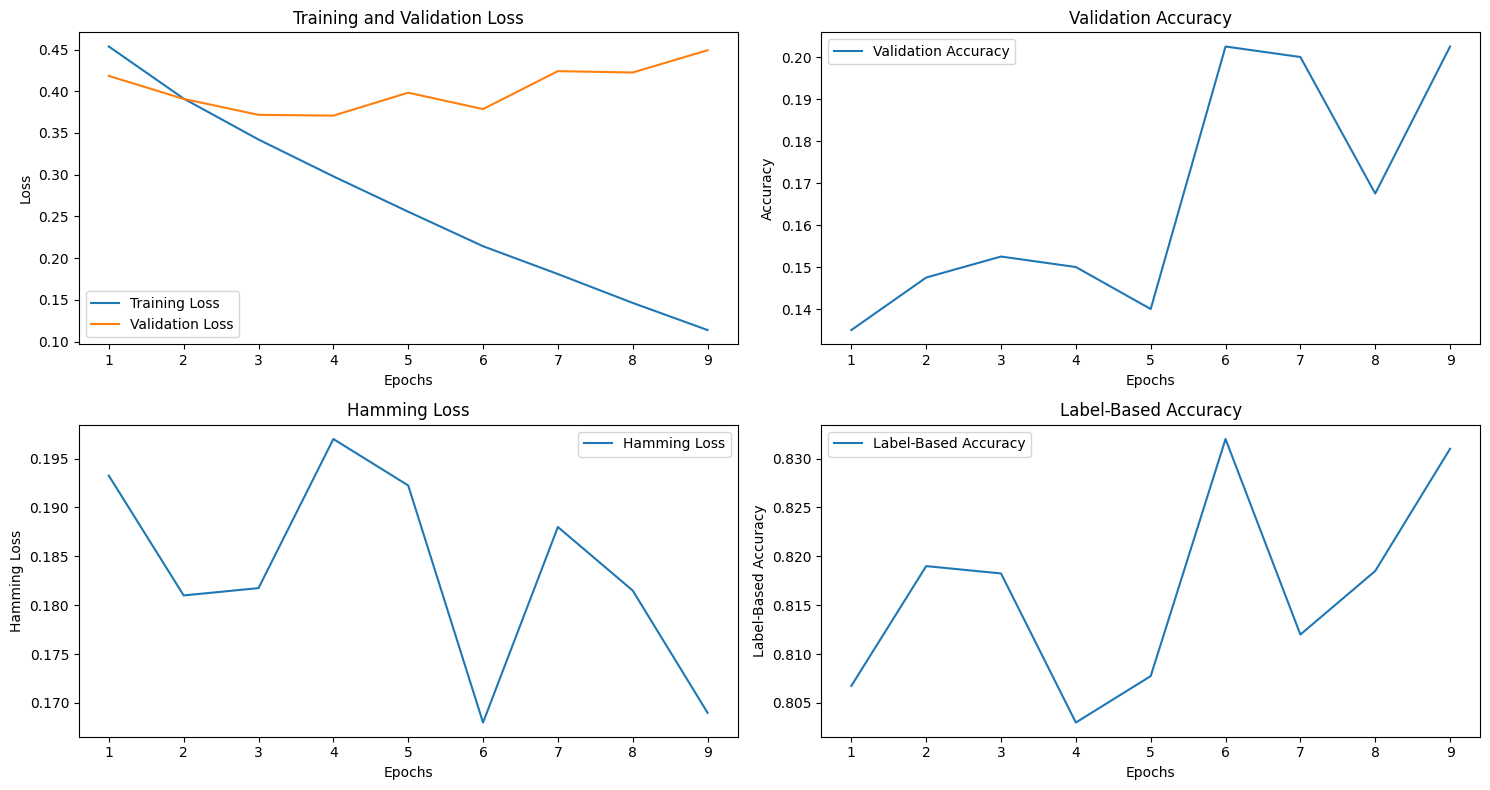

In [15]:
# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=mlb.classes_))

# Plot Training and Validation Metrics
plt.figure(figsize=(15, 8))

# Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Hamming Loss
plt.subplot(2, 2, 3)
plt.plot(range(1, len(hamming_losses) + 1), hamming_losses, label='Hamming Loss')
plt.title('Hamming Loss')
plt.xlabel('Epochs')
plt.ylabel('Hamming Loss')
plt.legend()

# Label-Based Accuracy
plt.subplot(2, 2, 4)
plt.plot(range(1, len(label_based_accuracies) + 1), label_based_accuracies, label='Label-Based Accuracy')
plt.title('Label-Based Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Label-Based Accuracy')
plt.legend()

plt.tight_layout()
plt.show()